# Mental health model

In [1]:
wd = r'D:\natcap\invest-mental-health\data'

import os
os.chdir(wd)
os.getcwd()

import re
import csv
import pandas as pd
import numpy as np
import geopandas as gpd

import rasterio
import matplotlib.pyplot as plt


### Import system modules
# import arcpy
# from arcpy import env
# import os, glob, fnmatch, sys
# from arcpy.sa import *
## Check out ArcGIS Spatial Analyst extension license
# arcpy.gp.CheckOutExtension("Spatial")
# ### Set environment settings
# arcpy.env.workspace = wd
# arcpy.env.overwriteOutput = True
# arcpy.env.compression = 'LZW'    # Lossless compression preserves all raster cell values


## Functions

In [26]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    #   for more colormap, see https://matplotlib.org/stable/users/explain/colors/colormaps.html

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

# Function to plot raster with a legend
def plot_raster_with_legend(raster_path):
    # Open the demand raster
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        # Get unique values
        unique_values = np.unique(data); print(unique_values)
        # Generate colors for each unique value
        N = len(unique_values)
        min_val = min(unique_values)
        max_val = max(unique_values)

    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 6))
    raster_show = plt.imshow(data, extent=extent,
              cmap=discrete_cmap(N, 'Set2'))  # adjust cmap as needed
    # Overlay the vector (shapefile)
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')  # adjust colors as needed
    fig.colorbar(raster_show, ax=ax, ticks=unique_values, fraction=0.036, pad=0.04)
    plt.clim(min_val-abs(min_val)*0.4, max_val+0.1) # set the color limits.
    ax.axis('off')  # Remove axis ticks and labels
    plt.show()




## Run the function 
# plot_raster_with_legend(files[0])

# Input data

## Shapefiles

In [14]:
# Load the shapefile
shapefile_path = 'cb_2019_us_county_500k_06075_clip.shp'
gdf = gpd.read_file(shapefile_path)




## Land cover 

### Load raw LC layer

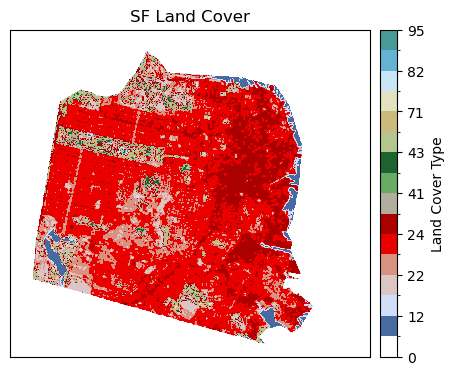

In [3]:

## load lulc map 
lc_img = "nlcd_2019_land_cover_SF.tif"

with rasterio.open(lc_img) as src:
    # Assuming an RGB image
    # Read the raster data as a numpy array
    land_cover = src.read(1)  # Read the first band; adjust if your data has multiple bands

    # Plotting parameters, considering the raster's metadata
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)


# Example color map (adjust the values and classes according to your data)
# NLCD class codes and corresponding colors (from the NLCD legend)
nlcd_class_values = {
    0: (0, 0, 0, 0),    # Transparent background
    11: "#476BA1",      # Open Water
    12: "#D1DEF8",      # Perennial Ice/Snow
    21: "#DEC5C5",      # Developed, Open Space
    22: "#D99282",      # Developed, Low Intensity
    23: "#EB0000",      # Developed, Medium Intensity
    24: "#AB0000",      # Developed, High Intensity
    31: "#B3AC9F",      # Barren Land
    41: "#68AB63",      # Deciduous Forest
    42: "#1C6330",      # Evergreen Forest
    43: "#B5C58F",      # Mixed Forest
    52: "#CCBA7C",      # Shrub/Scrub
    71: "#E2E2C1",      # Herbaceous
    81: "#C8E6F8",      # Hay/Pasture
    82: "#64B3D5",      # Cultivated Crops
    90: "#64ACD7",      # Woody Wetlands
    95: "#499996"       # Emergent Herbaceous Wetlands
}


lc_code_green = [11, 21, 41, 42, 43, 52, 71, 81]
lc_code_blue  = [11, 90, 95]

import matplotlib.colors as mcolors

# Create a color map from the defined colors
nlcd_cmap = mcolors.ListedColormap([nlcd_class_values[key] for key in sorted(nlcd_class_values.keys())])
nlcd_norm = mcolors.BoundaryNorm(sorted(nlcd_class_values.keys()), nlcd_cmap.N)



# Create a plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('SF Land Cover', loc='center')
cax = ax.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)

# Create a new axes on the right of the current axes for the colorbar
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('Land Cover Type')

# Remove the x and y ticks and labels
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlabel('')  # Remove x-axis label if previously set
ax.set_ylabel('')  # Remove y-axis label if previously set

plt.show()



### Reclassify lc

In [4]:
# Open the NLCD GeoTIFF file
with rasterio.open(lc_img) as src:
    # Read the data into a variable
    nlcd_data = src.read(1)  # Assuming the land cover data is in the first band

    # List of developed land cover codes
    developed_codes = [21, 22, 23, 24, 82]

    # Change all developed land cover codes to 0
    for code in developed_codes:
        nlcd_data[nlcd_data == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta



#### Subset lc type(s) of interest

In [5]:
## Only take forest as greenspace -------------------------------------------------------

lc_code_i = [41, 42, 43]    ## Forest
lc_code_i = [71, 81]        ## Grass
lc_code_i = [11]
lc_code_i = lc_code_green   ## Green spaces


delimiter = '_'

lc_code_string = delimiter.join([i if type(i) == float else str(i) for i in lc_code_i])
# print(lc_code_string)

with rasterio.open(lc_img) as src:
    # Read the data into a variable
    lc_i = src.read(1)  # Assuming the land cover data is in the first band
    lc_code_all = np.unique(lc_i[~np.isnan(lc_i)])  # Exclude NaN values for unique count
    print("Unique values:", lc_code_all)

    # List of developed land cover codes
    lc_code_remove = np.setdiff1d(lc_code_all, lc_code_i)
    print(lc_code_remove)

    # Change all developed land cover codes to 0
    for code in lc_code_remove:
        lc_i[lc_i == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta
    nlcd_crs = src.crs  # Get the CRS of the raster


# Path for the modified output file
output_path = lc_img.replace('.tif', '_') + lc_code_string + '.tif'; print(output_path)
# Write the modified data back to a new GeoTIFF file
with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(lc_i, 1)  # Write modified data to the first band



Unique values: [-128   11   21   22   23   24   31   41   42   43   52   71   81   82
   90   95]
[-128   22   23   24   31   82   90   95]
nlcd_2019_land_cover_SF_11_21_41_42_43_52_71_81.tif


### Plot

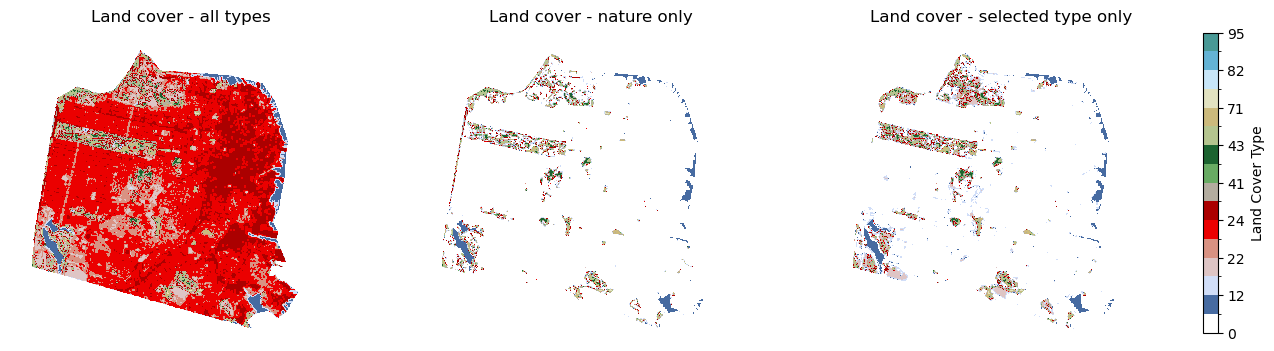

In [6]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot first dataset
img1 = ax1.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)
ax1.set_title('Land cover - all types')
ax1.axis('off')  # Remove axis ticks and labels

# Plot second dataset
img2 = ax2.imshow(nlcd_data, cmap=nlcd_cmap, norm=nlcd_norm)
ax2.set_title('Land cover - nature only')
ax2.axis('off')  # Remove axis ticks and labels

img3 = ax3.imshow(lc_i, cmap=nlcd_cmap, norm=nlcd_norm)
ax3.set_title('Land cover - selected type only')
ax3.axis('off')  # Remove axis ticks and labels

## Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])  # Adjust colorbar position and size: # [left, bottom, width, height]
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('Land Cover Type')

plt.show()

### Count by nature LC type

In [7]:
# Step 3: Count Each Land Cover Type

# Unique values and their counts
unique, counts = np.unique(lc_i, return_counts=True)
land_cover_counts = dict(zip(unique, counts))

nlcd_labels = {
    11: "Open Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Herbaceous",
    81: "Hay/Pasture",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

# Replace codes with labels
land_cover_counts_named = {nlcd_labels[code]: count for code, count in land_cover_counts.items() if code in nlcd_labels}


# Create DataFrame
land_cover_df = pd.DataFrame(list(land_cover_counts_named.items()), columns=['Land Cover Type', 'Count'])

# Display the DataFrame
print(land_cover_df)


         Land Cover Type  Count
0             Open Water   5478
1  Developed, Open Space   9413
2       Deciduous Forest      6
3       Evergreen Forest   3197
4           Mixed Forest    977
5            Shrub/Scrub   1170
6             Herbaceous   2116
7            Hay/Pasture     11


### Mask NDVI with slected Green space

[ 0 11 21 41 42 43 52 71 81]


C:\Users\pc\AppData\Local\Temp\ipykernel_54952\1884545238.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


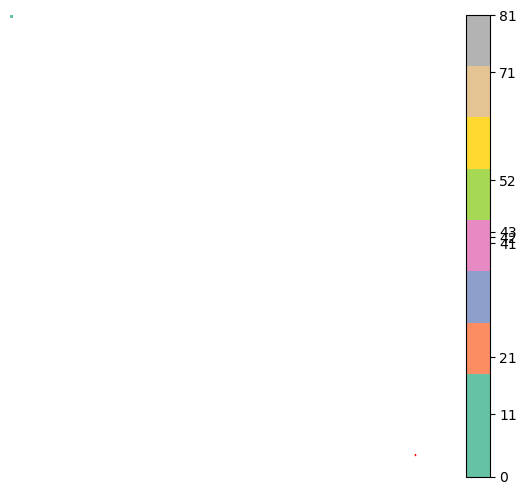

In [30]:
# Read NDVI image
ndvi_path = 'ndvi_s2_075_2019_10m.tif'
land_cover_path = 'nlcd_2019_land_cover_SF_11_21_41_42_43_52_71_81.tif'


with rasterio.open(ndvi_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)  # Assuming NDVI data is in the first band
    ndvi_profile = ndvi_src.profile
    ndvi_meta = ndvi_src.meta
    ndvi_crs = ndvi_src.crs
    ndvi_transform = ndvi_src.transform

# Read land cover image
with rasterio.open(land_cover_path) as src:
    land_cover_data = src.read(1)  # Assuming land cover data is in the first band
    # Replace 0 values with NaN in the land cover image
    land_cover_data = np.where(land_cover_data == 0, np.nan, land_cover_data)
    land_cover_profile = src.profile


plot_raster_with_legend(land_cover_path)  

In [21]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Reproject and resample the land cover image to match the NDVI image
with rasterio.open(land_cover_path) as lc_src:
    transform, width, height = calculate_default_transform(
        lc_src.crs, ndvi_crs, lc_src.width, lc_src.height, *lc_src.bounds)
    
    land_cover_resampled = np.empty(shape=(ndvi_meta['height'], ndvi_meta['width']), dtype=land_cover_data.dtype)
    
    reproject(
        source=land_cover_data,
        destination=land_cover_resampled,
        src_transform=lc_src.transform,
        src_crs=lc_src.crs,
        dst_transform=ndvi_transform,
        dst_crs=ndvi_crs,
        resampling=Resampling.nearest)

# Define the land cover value representing the forest
forest_value = 41  # Adjust this value based on your land cover classification

# Create a mask where the land cover is forest
forest_mask = land_cover_resampled == forest_value

# Apply the mask to the NDVI image
clipped_ndvi = np.where(forest_mask, ndvi_data, np.nan)

# Update the metadata to reflect the new data type and number of bands
ndvi_meta.update(dtype=rasterio.float32, count=1)

# Path to save the clipped NDVI image
clipped_ndvi_path = 'ndvi_clipped.tif'

# Save the clipped NDVI image
with rasterio.open(clipped_ndvi_path, 'w', **ndvi_meta) as dst:
    dst.write(clipped_ndvi.astype(rasterio.float32), 1)

print("Clipped NDVI image saved successfully.")

Clipped NDVI image saved successfully.


## Nature exposure - UNA


### Run UNA model first 


In [257]:
#


### Load UNA model outputs

In [258]:

# File paths for the two NLCD datasets

# file_path1 = './output/accessible_urban_nature_lucode_42.tif'
# file_path1 = 'usa_ppp_2020_UNadj_constrained_SF_proj_NoDataTo0.tif'
file_path1 = './output/urban_nature_demand_' + lc_code_string + '.tif'
file_path2 = './output/urban_nature_supply_percapita_' + lc_code_string + '.tif'



# Create a colormap from the NLCD color codes
nlcd_cmap = mcolors.ListedColormap([nlcd_class_values[key] for key in sorted(nlcd_class_values.keys())])
nlcd_norm = mcolors.BoundaryNorm(sorted(nlcd_class_values.keys()), nlcd_cmap.N)

# # Read the raster data
# with rasterio.open(file_path1) as src1, rasterio.open(file_path2) as src2:
#     data1 = src1.read(1)  # First dataset
#     # Mask no-data values
#     data1 = np.where(data1 == no_data_value, np.nan, data1)
#     data1_extent = [src_1.bounds.left, src_1.bounds.right, src_1.bounds.bottom, src_1.bounds.top]


#     nat_sup = src2.read(1)  # Second dataset
#     nat_sup = np.where(nat_sup == no_data_value, np.nan, nat_sup)

# # Define the no-data value if known (e.g., -9999 or 0)
no_data_value = -9999  # Update this value based on your data's specifics

# Open the demand raster
with rasterio.open(file_path1) as src_1:
    data1 = src_1.read(1)  # Read the first band
    # Mask no-data values
    
    # data1 = np.where(data1 == no_data_value, np.nan, data1)
    # Mask no-data values to NaN for transparency
    data1[data1 < 0] = np.nan ## 
    data1_bounds = src_1.bounds
    data1_extent = [data1_bounds.left, data1_bounds.right, data1_bounds.bottom, data1_bounds.top]

    # data1_extent = [src_1.bounds.left, src_1.bounds.right, src_1.bounds.bottom, src_1.bounds.top]

# Open the supply raster
with rasterio.open(file_path2) as src2:
    nat_sup = src2.read(1)  # Read the first band
    # Mask no-data values
    nat_sup = np.where(nat_sup == no_data_value, np.nan, nat_sup)
    nat_extent = [src2.bounds.left, src2.bounds.right, src2.bounds.bottom, src2.bounds.top]
    raster_crs = src2.crs  # Get the CRS of the raster
    dem_transform = src2.transform
    raster_profile = src2.profile  # We'll use this for writing output


# ## use histgram to identify the NoData values, and to fix color-show issue on the map
# from rasterio.plot import show_hist
# show_hist(data1, bins=50, lw=0.0, stacked=False, alpha=0.3,
#     histtype='stepfilled', title="Histogram")



## Reproject the Shapefile
# Check if the CRS matches, and reproject if necessary
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

gdf2 = gdf
if gdf2.crs != nlcd_crs:
    gdf2 = gdf2.to_crs(nlcd_crs)



### Reproject NLCD raster

In [259]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

target_crs = raster_crs

# Path to the NLCD raster
nlcd_path = 'nlcd_2019_land_cover_SF_' + lc_code_string + '.tif'
     
# Open the NLCD raster and reproject it if necessary
with rasterio.open(nlcd_path) as nlcd:
    nlcd_data = nlcd.read(1)  # Assume NLCD data is in the first band
    nlcd_transform = nlcd.transform
    nlcd_crs = nlcd.crs

    if nlcd_crs != target_crs:
        print("Reprojecting NLCD raster...")
        # Calculate the new transform and dimensions for the NLCD raster
        transform, width, height = calculate_default_transform(
            nlcd.crs, target_crs, nlcd.width, nlcd.height, *nlcd.bounds)
        # Create a new array to hold the reprojected NLCD data
        reprojected_nlcd = np.empty((height, width), dtype=nlcd_data.dtype)
        # Reproject the NLCD data
        reproject(
            source=nlcd_data,
            destination=reprojected_nlcd,
            src_transform=nlcd_transform,
            src_crs=nlcd_crs,
            dst_transform=dem_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest)
    else:
        print("No reprojection needed.")
        reprojected_nlcd = nlcd_data
        transform = nlcd_transform

nodata = -128
reprojected_nlcd = np.ma.masked_values(reprojected_nlcd, nodata)
nodata = 0
reprojected_nlcd = np.ma.masked_values(reprojected_nlcd, nodata)

No reprojection needed.


### Plot

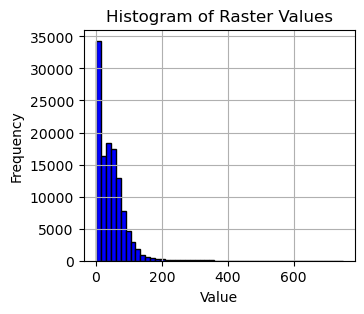

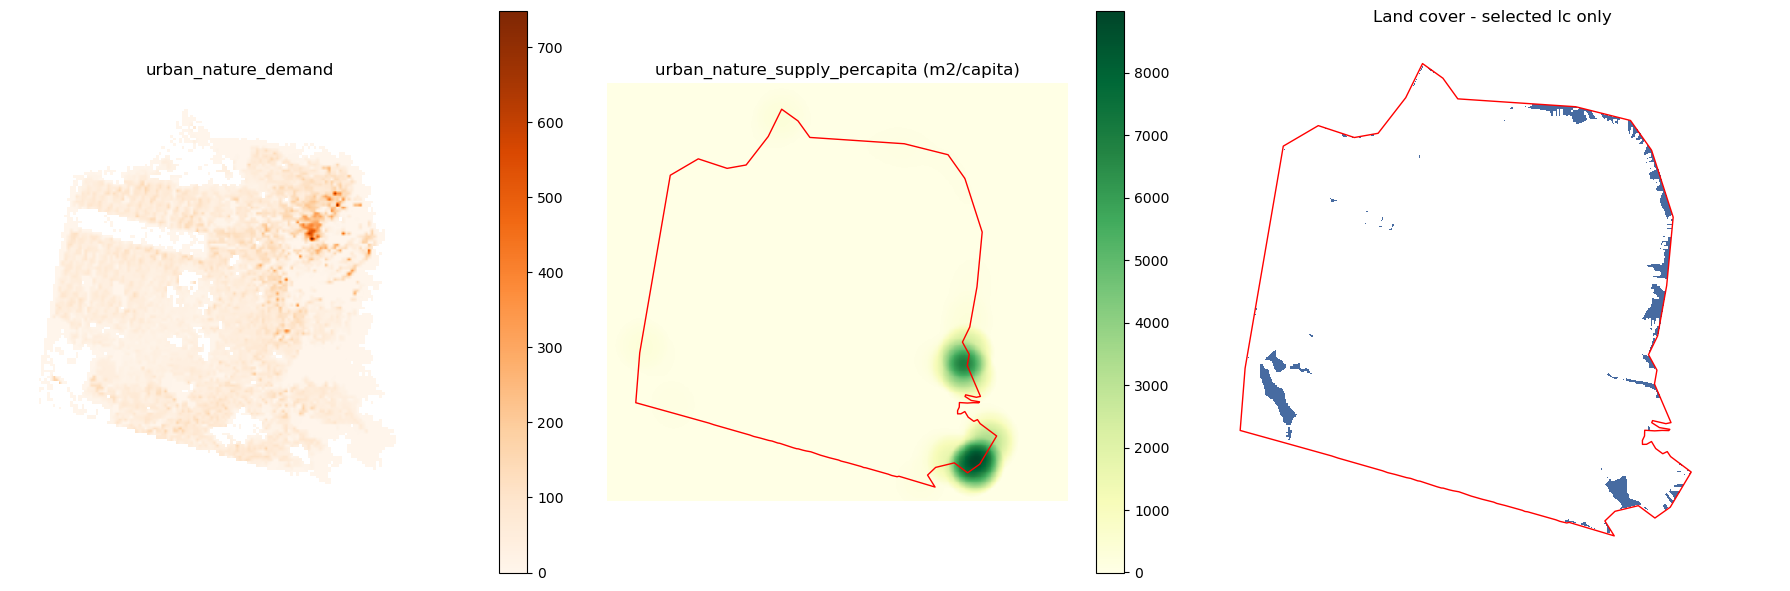

In [264]:

# Assuming the no-data value is known
no_data_value = src.nodata  # Or set it manually if not defined
# Mask no-data values
data1 = np.ma.masked_equal(data1, no_data_value)
plt.figure(figsize=(3.5, 3))
plt.hist(data1.compressed(), bins=50, color='blue', edgecolor='black')  # Compressed removes the masked values from the array
plt.title('Histogram of Raster Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

## Plot urban_nature_demand
cax1 = ax1.imshow(data1, cmap='Oranges', extent=data1_extent, interpolation='nearest')
ax1.set_title('urban_nature_demand')
ax1.axis('off')  # Remove axis ticks and labels
fig.colorbar(cax1, ax=ax1, orientation='vertical')
# Overlay the shapefile
ax1.set_xlim(data1_extent[0], data1_extent[1])
ax1.set_ylim(data1_extent[2], data1_extent[3])


## Plot urban_nature_supply_percapita
cax2 = ax2.imshow(nat_sup, cmap='YlGn', extent=nat_extent, interpolation='nearest')
ax2.set_title('urban_nature_supply_percapita (m2/capita)')
ax2.axis('off')  # Remove axis ticks and labels
fig.colorbar(cax2, ax=ax2, orientation='vertical')
gdf.plot(ax=ax2, edgecolor='red', facecolor='none')  # Adjust colors

## plot NLCD 
# img3 = ax3.imshow(reprojected_nlcd, cmap=nlcd_cmap, norm=nlcd_norm)
cax3 = ax3.imshow(reprojected_nlcd, 
                  # cmap='winter', #, 'Dark2',
                  # cmap=cmap, # norm=norm,
                  cmap=nlcd_cmap, norm=nlcd_norm, 
                  extent=extent)
ax3.set_title('Land cover - selected lc only')
ax3.axis('off')  # Remove axis ticks and labels
# gdf2.plot(ax=ax3, edgecolor='red', facecolor='none')  # Adjust colors
gdf.plot(ax=ax3, edgecolor='red', facecolor='none')  # Adjust colors
# fig.colorbar(cax3, ax=ax3, orientation='vertical')

# # Add a colorbar with labels for each unique value
# cbar = fig.colorbar(cax3, ticks=np.arange(min(unique_values), max(unique_values)+1))
# cbar.set_ticklabels(unique_values)
# cbar.set_label('Unique Values')

# Display the plots
plt.tight_layout()
plt.show()



### To determine what counts as "nature exposure"?

threshold:  3.38


C:\Users\pc\AppData\Local\Temp\ipykernel_36444\2369929709.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


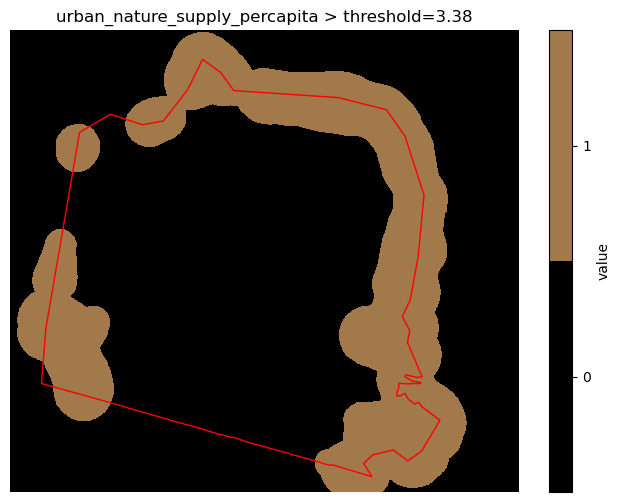

In [261]:
# Compute the median value of the DEM
threshold = np.nanmedian(nat_sup[nat_sup != src.nodata])  # Exclude no-data values in the calculation
threshold = np.percentile(nat_sup[nat_sup != src.nodata], 75)

threshold = round(threshold, 2)
print('threshold: ', threshold)


# Reclassify the DEM
nat_sup_nat1 = np.where(nat_sup > threshold, 1, 0)
# Mask out the no-data areas to keep them unchanged
nat_sup_nat1[nat_sup == src.nodata] = src.nodata



# Function to generate random colors
import random
def generate_colors(num_colors):
    colors = []
    for i in range(num_colors):
        colors.append('#%06X' % random.randint(0, 0xFFFFFF))
    return colors


# Get unique values
unique_values = np.unique(nat_sup_nat1)
# print("Unique values:", unique_values)
# Generate colors for each unique value
N = len(unique_values)
colors = generate_colors(N)
min_val = min(unique_values)
max_val = max(unique_values)
# print(min_val)
# print(max_val)
# print(N)



# Path for the reclassified DEM
nat_sup_nat1_path = 'nat_sup_nat1.tif'

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the raster
raster_show = plt.imshow(nat_sup_nat1, 
                        #  cmap='gray', interpolation='none',
                        #  cmap=cmap, norm=norm,
                        #  cmap=discrete_cmap(N, min_val, max_val,  'cubehelix'),
                         cmap=discrete_cmap(N, 'cubehelix'),
                         extent=nat_extent)  # adjust cmap as needed
# Overlay the vector (shapefile)
gdf.plot(ax=ax, facecolor='none', edgecolor='red')  # adjust colors as needed
# Optional: add a colorbar
cbar = fig.colorbar(raster_show, ax=ax,
                    # ticks=unique_values,
                    # ticks=np.arange(np.min(unique_values), np.max(unique_values) + 1), 
                    ticks=range(N),
                    fraction=0.036, pad=0.04, label='value')
plt.clim(-0.5, N - 0.5)
ax.set_title('urban_nature_supply_percapita > threshold=' + str(threshold))
ax.axis('off')  # Remove axis ticks and labels
plt.show()



## Effect size

### Parameter table

In [262]:

## load lulc table
lc_xls = "lulc-attributes_NLCD_SF3.xlsx"
lc_tab = pd.read_excel(lc_xls, engine='openpyxl')
lc_tab


,lulc_code,NLCD_Land,nature_yes,search_radius_m,nature_code,effect_size_anxiety,effect_size_depression
0,11,Open Water,1,1000,1201,-0.413858,-0.374721
1,21,"Developed, Open Space",1,1000,1005,-0.474147,-0.173643
2,22,"Developed, Low Intensity",0,1000,9999,0.000000,0.000000
3,23,"Developed, Medium Intensity",0,1000,9999,0.000000,0.000000
4,24,"Developed, High Intensity",0,1000,9999,0.000000,0.000000
5,31,Barren Land,1,1000,1000,0.000000,0.000000
6,41,Deciduous Forest,1,1000,1001,-1.582706,-0.903320
7,42,Evergreen Forest,1,1000,1001,-1.582706,-0.903320
8,43,Mixed Forest,1,1000,1001,-1.582706,-0.903320
9,52,Shrub/Scrub,1,1000,1002,NaN,NaN


### Map 

1201
-0.413857558776701
Unique values: [-0.41  0.  ]
N2: 2
effect_size_anxiety_1201.tif


C:\Users\pc\AppData\Local\Temp\ipykernel_36444\2369929709.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


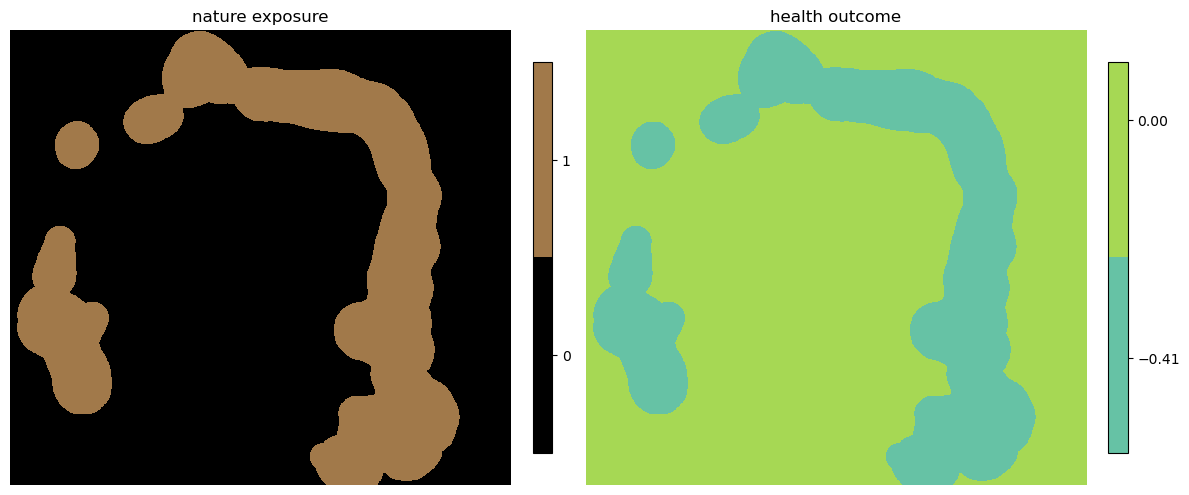

In [263]:
## 1. Locate `nature_code`
df = lc_tab[['lulc_code', 'nature_code']]
nature_code = df.loc[df['lulc_code'].isin(lc_code_i)]

# Get the unique values of 'B' column
nature_code_i = nature_code['nature_code'].unique()[0]
print(nature_code_i)

## 2. Locate effect size 
# Assume you need a specific value from a column named 'Parameter'
mh_indicator = 'effect_size_anxiety'
value_from_excel = lc_tab.loc[lc_tab['nature_code'] == nature_code_i, mh_indicator].values[0]

print(value_from_excel)


## 3. Calculate new raster values
# E.g., multiply each pixel by the value from Excel
es_i = nat_sup_nat1 * value_from_excel

# Handle no-data values appropriately
es_i[nat_sup_nat1 == src.nodata] = src.nodata



# Function to process raster data
def process_raster_data(data):
    # Ensure all values are float
    data = data.astype(np.float32)
    # Round values to two decimal places
    data = np.round(data, 2)
    # Replace -0.0 with 0.0 and handle 0.0 appropriately
    data = np.where(np.isclose(data, -0.0), 0, data)
    data = np.where(np.isclose(data, 0.0), 0, data)
    return data
# Process raster data to replace -0.0 with 0.0
es_i = process_raster_data(es_i)

# Get unique values
unique_values2 = np.unique(es_i)
print("Unique values:", unique_values2)
# Generate colors for each unique value
N2 = len(unique_values2)
print("N2:", N2)
min_val2 = min(unique_values2)
max_val2 = max(unique_values2)


## Save the Calculated Raster
output_raster_path = mh_indicator + '_' + str(nature_code_i) + '.tif'
print(output_raster_path)

# Write the new raster data
with rasterio.open(output_raster_path, 'w', **raster_profile) as dst:
    dst.write(es_i, 1)



## Visualizing the Result 

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(nat_sup_nat1, 
        #    cmap='viridis', 
           cmap=discrete_cmap(N, 'cubehelix'))
plt.title('nature exposure')
plt.colorbar(ticks=range(N), fraction=0.036, pad=0.04)
plt.clim(-0.5, N - 0.5)
plt.axis('off') 


plt.subplot(1, 2, 2)
plt.imshow(es_i, 
        #    cmap='viridis')
        # cmap=discrete_cmap(N2, min_val2, max_val2,'cubehelix'))
           cmap=discrete_cmap(N2, 'Set2'))
plt.title('health outcome')
plt.colorbar(ticks=unique_values2, fraction=0.036, pad=0.04)
plt.clim(min_val2-abs(min_val2)*0.4, max_val2+0.1) # set the color limits.
plt.axis('off') 
plt.tight_layout()
plt.show()


# Overall effect 

In [289]:

files = [f for f in os.listdir('.') if re.match(r'effect_size_+.*\.tif', f)]
print(files)

file = files[0]


# Function to read raster data
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        profile = src.profile
    return data, profile

# Read the three rasters
data1, profile1 = read_raster(files[0])
data2, profile2 = read_raster(files[1])
data3, profile3 = read_raster(files[2])

# Ensure that the dimensions of all rasters are the same
assert data1.shape == data2.shape == data3.shape, "All rasters must have the same dimensions"

# Calculate the minimum value at each pixel location
min_data = np.minimum(np.minimum(data1, data2), data3)

# Path to the output raster
output_path = 'effect_size_anxiety_final.tif'

# Update profile to match the data type of the minimum values
profile1.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw'
)

# Write the output raster
with rasterio.open(output_path, 'w', **profile1) as dst:
    dst.write(min_data.astype(rasterio.float32), 1)


['effect_size_anxiety_1001.tif', 'effect_size_anxiety_1003.tif', 'effect_size_anxiety_1201.tif', 'effect_size_anxiety_final.tif']


## Plot

[-1.58 -0.63 -0.41  0.  ]


C:\Users\pc\AppData\Local\Temp\ipykernel_36444\2369929709.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


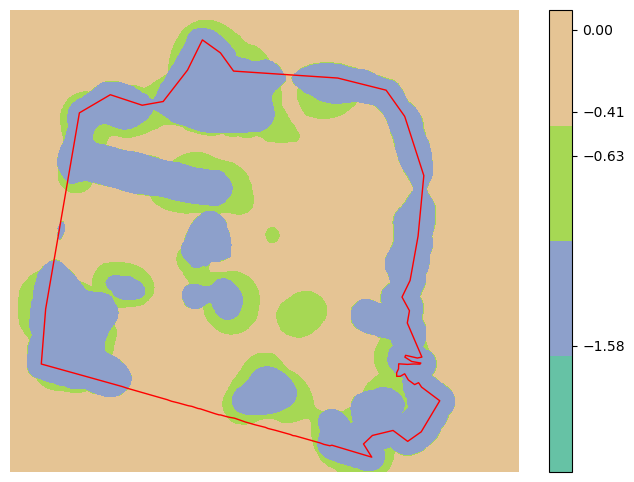

In [290]:

## Run the function 
# plot_raster_with_legend(files[0])
# plot_raster_with_legend(files[1])
# plot_raster_with_legend(files[2])

plot_raster_with_legend(files[3])

# Illustartions

## LC

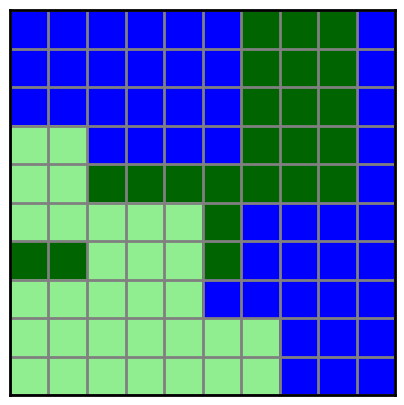

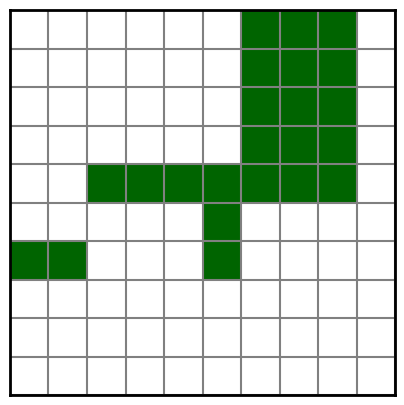

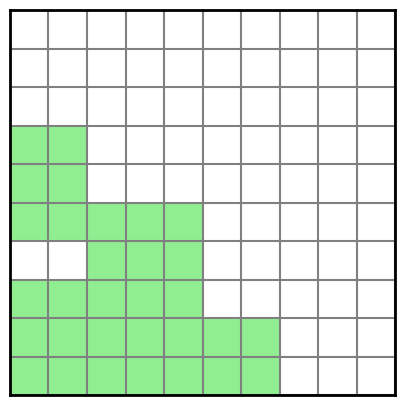

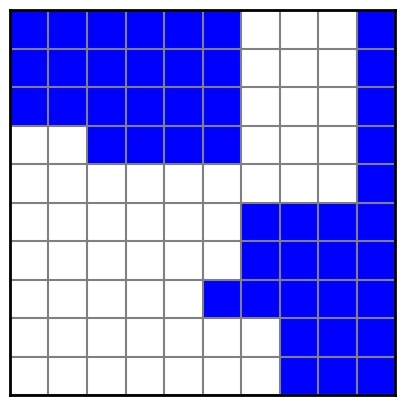

In [328]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Define the size of the map
size = 10

# Define land cover types
land_covers = {
    0: 'water body',  # blue
    1: 'forest',      # green
    2: 'grassland'    # yellow
}

# Create a blank map
map_layer = np.zeros((size, size), dtype=int)

# Function to add clusters of a specific land cover type
def add_cluster(map_layer, land_cover_type, cluster_size):
    for _ in range(cluster_size):
        x, y = np.random.randint(0, size, size=2)
        map_layer[max(0, x-1):min(size, x+2), max(0, y-1):min(size, y+2)] = land_cover_type
    return map_layer

# Add clusters for each land cover type
map_layer = add_cluster(map_layer, 0, 5)  # water body
map_layer = add_cluster(map_layer, 1, 5)  # forest
map_layer = add_cluster(map_layer, 2, 5)  # grassland

# # Plot the map
# plt.figure(figsize=(5, 5))
# plt.imshow(map_layer, cmap='viridis', interpolation='nearest')
# plt.colorbar(ticks=[0, 1, 2], label='Land Cover')
# plt.clim(-0.5, 2.5)
# plt.xticks([]), plt.yticks([])
# plt.show()

import pandas as pd
# import ace_tools as tools

# Convert map_layer to a DataFrame
map_layer_df = pd.DataFrame(map_layer)
# tools.display_dataframe_to_user(name="Clustered Land Cover Map", dataframe=map_layer_df)
# map_layer_df



# Update color mapping
cmap = {
    0: 'blue',      # water body
    1: 'darkgreen', # forest
    2: 'lightgreen' # grassland
}

# Plot the map with updated colors
fig, ax = plt.subplots(figsize=(5, 5))
colors = np.array([cmap[val] for val in map_layer.flatten()]).reshape(map_layer.shape)
ax.imshow(map_layer, cmap=plt.cm.colors.ListedColormap([cmap[0], cmap[1], cmap[2]]), interpolation='nearest')
# plt.colorbar(ticks=[0, 1, 2], label='Land Cover')
# plt.clim(-0.5, 2.5)

## Remove axis and frame
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)
ax.tick_params(which='minor', size=0)
ax.set_xticks([])
ax.set_yticks([])
# Add solid black outer border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.savefig(fname = 'example_lc.png', bbox_inches='tight')
plt.show()

# Create separate layers for each land cover type
forest_layer = np.where(map_layer == 1, 1, 0)
grassland_layer = np.where(map_layer == 2, 1, 0)
water_body_layer = np.where(map_layer == 0, 1, 0)

# Plot each layer without titles and with a light gray grid border
def plot_layer_no_title_no_axis_savePNG(layer, color, filename):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(layer, cmap=plt.cm.colors.ListedColormap(['white', color]), interpolation='nearest')
    
    # Remove axis and frame
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1.5)
    ax.tick_params(which='minor', size=0)
    ax.set_xticks([])
    ax.set_yticks([])

    # Add solid black outer border
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    # Save to file
    plt.savefig(f'{filename}', bbox_inches='tight', pad_inches=0.1)
    # plt.close()
    plt.show()

# Plot each layer with the specified colors without titles and with grid border
# Save each layer with the specified colors as PNG
plot_layer_no_title_no_axis_savePNG(forest_layer,      'darkgreen',     'example_lc_forest_layer.png')
plot_layer_no_title_no_axis_savePNG(grassland_layer,    'lightgreen',   'example_lc_grassland_layer.png')
plot_layer_no_title_no_axis_savePNG(water_body_layer,   'blue',         'example_lc_water_body_layer.png')


## Population layer

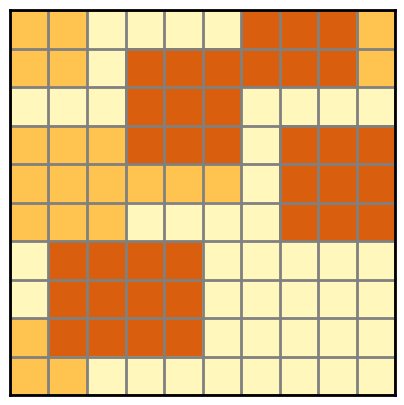

In [329]:
# Set the seed for reproducibility
np.random.seed(123)

# Define the size of the map
size = 10

# Define land cover types
land_covers = {
    0: 'pop1',  # blue
    1: 'pop2',      # green
    2: 'pop3'    # yellow
}

# Create a blank map
map_layer = np.zeros((size, size), dtype=int)

# Function to add clusters of a specific land cover type
def add_cluster(map_layer, land_cover_type, cluster_size):
    for _ in range(cluster_size):
        x, y = np.random.randint(0, size, size=2)
        map_layer[max(0, x-1):min(size, x+2), max(0, y-1):min(size, y+2)] = land_cover_type
    return map_layer

# Add clusters for each land cover type
map_layer = add_cluster(map_layer, 0, 5)  # water body
map_layer = add_cluster(map_layer, 1, 5)  # forest
map_layer = add_cluster(map_layer, 2, 5)  # grassland


# Convert map_layer to a DataFrame
map_layer_df = pd.DataFrame(map_layer)

# Update color mapping
cmap = {
    0: '#fff7bc',      # water body
    1: '#fec44f', # forest
    2: '#d95f0e' # grassland
}

# Plot the map with updated colors
fig, ax = plt.subplots(figsize=(5, 5))
colors = np.array([cmap[val] for val in map_layer.flatten()]).reshape(map_layer.shape)
ax.imshow(map_layer, cmap=plt.cm.colors.ListedColormap([cmap[0], cmap[1], cmap[2]]), interpolation='nearest')

## Remove axis and frame
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)
ax.tick_params(which='minor', size=0)
ax.set_xticks([])
ax.set_yticks([])
# Add solid black outer border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.savefig(fname = 'example_pop.png', bbox_inches='tight')
plt.show()